# GAN para creación de prendas de ropa
Usamos el dataset MNIST para entrenar una red neuronal generativa antagónica para generar prendas de ropa.

In [ ]:
# Importa las librerías necesarias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import random
import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam

Cargamos el dataset

In [ ]:
# Cargar dataset
fashion_mnist = keras.datasets.fashion_mnist

Obtenemos los datos de entrenamiento y sus labels correspondientes

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

# Etiquetas de las clases de Fashion MNIST
class_names = ['Camiseta/Top', 'Pantalón', 'Suéter', 'Vestido', 'Abrigo',
               'Sandalia', 'Camisa', 'Zapatilla deportiva', 'Bolso', 'Botín']

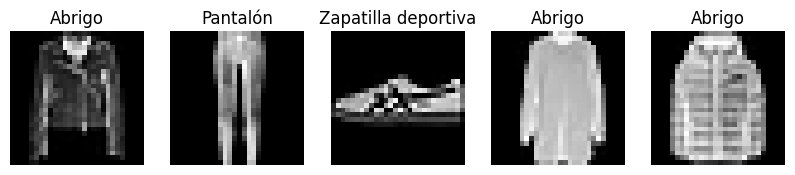

In [ ]:
# Seleccionar 5 imágenes aleatorias
indices = np.random.choice(len(train_images), 5, replace=False)
sample_images = train_images[indices]
sample_labels = train_labels[indices]

# Graficar las imágenes
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_images[i], cmap="gray")
    plt.title(class_names[sample_labels[i]])
    plt.axis("off")

plt.show()

In [ ]:
# Creamos el dataset de entrenamiento
train_images = (train_images.astype(np.float32) - 127.5) / 127.5
train_images = np.expand_dims(train_images, axis=-1)

BATCH_SIZE = 256
BUFFER_SIZE = 60000
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# Verifica la estructura del dataset
for batch in train_dataset.take(1):
  print("Dimensiones del lote:", batch.shape)
  print("Rango: de", batch.numpy().min(), "a", batch.numpy().max())

Dimensiones del lote: (256, 28, 28, 1)
Rango: de -1.0 a 1.0


Creación del generador

In [ ]:
LATENT_DIM = 100

generator = keras.Sequential([
    layers.Dense(7 * 7 * 256, input_shape=(LATENT_DIM,)),  # 7x7x256
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Reshape((7, 7, 256)),  # Redimensionar a 7x7x256

    layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding="same", activation="tanh")  # Genera (28, 28, 1)
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Dimensiones por capa

noise = tf.random.normal([1, LATENT_DIM])
x = noise
for layer in generator.layers:
  x = layer(x)
  print(f"{layer.name}: {x.shape}")

dense: (1, 12544)
batch_normalization: (1, 12544)
leaky_re_lu: (1, 12544)
reshape: (1, 7, 7, 256)
conv2d_transpose: (1, 14, 14, 128)
batch_normalization_1: (1, 14, 14, 128)
leaky_re_lu_1: (1, 14, 14, 128)
conv2d_transpose_1: (1, 28, 28, 64)
batch_normalization_2: (1, 28, 28, 64)
leaky_re_lu_2: (1, 28, 28, 64)
conv2d_transpose_2: (1, 28, 28, 1)


In [ ]:
generated_image = generator(noise, training=False)
print("Dimensiones de la imagen generada:", generated_image.shape)

Dimensiones de la imagen generada: (1, 28, 28, 1)


Dimensiones de la imagen generada: (1, 28, 28, 1)
Rango de valores de la imagen generada: de -0.073532455 a 0.045107868


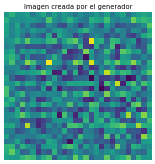

In [ ]:
noise = tf.random.normal([1, LATENT_DIM])

# Genera una imagen utilizando el generador
generated_image = generator(noise, training=False)

# Muestra las dimensiones de la imagen generada
print("Dimensiones de la imagen generada:", generated_image.shape)

# Verifica el rango de valores de la imagen generada
print("Rango de valores de la imagen generada: de", generated_image.numpy().min(), "a", generated_image.numpy().max())

# Muestra la imagen generada
plt.figure(dpi=40)
plt.imshow((generated_image[0] + 1) / 2) # Reescala la imagen al rango [0, 1] para visualizarla
plt.axis("off")
plt.title("Imagen creada por el generador")
plt.show()

Creación del discriminador

In [ ]:
LATENT_DIM = 100
discriminator = keras.Sequential([
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=(28, 28, 1)),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(1, activation="sigmoid")  # Decide si la imagen es real o generada
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Prueba el discriminador con una imagen creada por el generador
noise = tf.random.normal([1, LATENT_DIM])
generated_image = generator(noise, training=False)

# Pasa la imagen por el discriminador
decision = discriminator(generated_image)
print("Decisión del discriminador (valor cercano a 0 = falsa, 1 = real):", decision.numpy())

Decisión del discriminador (valor cercano a 0 = falsa, 1 = real): [[0.5002108]]


In [ ]:
EPOCHS = 10
# Inicializa los optimizadores y la función de pérdida
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=False)  # No se necesita logits porque la última capa era una sigmoide
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

Época 1/10
Pérdida del discriminador: 1.3826813697814941, Pérdida del generador: 0.7112518548965454
Pérdida del discriminador: 1.3831000328063965, Pérdida del generador: 0.6801532506942749
Pérdida del discriminador: 1.3968398571014404, Pérdida del generador: 0.6543123126029968
Pérdida del discriminador: 1.3896691799163818, Pérdida del generador: 0.6453640460968018
Pérdida del discriminador: 1.3732075691223145, Pérdida del generador: 0.6498889923095703
Pérdida del discriminador: 1.3635977506637573, Pérdida del generador: 0.6632472276687622
Pérdida del discriminador: 1.324478268623352, Pérdida del generador: 0.679008960723877
Pérdida del discriminador: 1.3002259731292725, Pérdida del generador: 0.6959251165390015
Pérdida del discriminador: 1.274264931678772, Pérdida del generador: 0.7130966186523438
Pérdida del discriminador: 1.262956142425537, Pérdida del generador: 0.7336270213127136
Pérdida del discriminador: 1.2094415426254272, Pérdida del generador: 0.753483235836029
Pérdida del dis

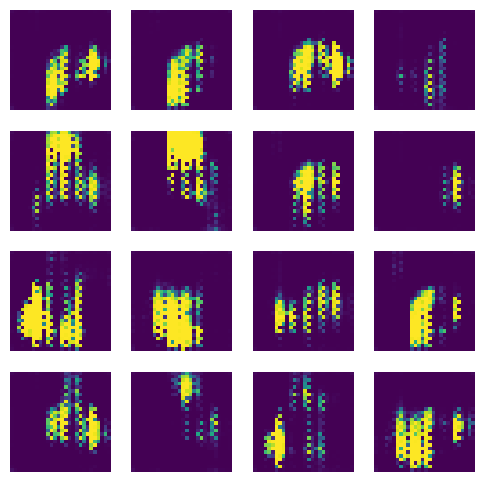

Época 3/10
Pérdida del discriminador: 1.283076524734497, Pérdida del generador: 0.9240997433662415
Pérdida del discriminador: 1.273198127746582, Pérdida del generador: 0.9175381660461426
Pérdida del discriminador: 1.217759132385254, Pérdida del generador: 0.9247111678123474
Pérdida del discriminador: 1.2272510528564453, Pérdida del generador: 0.9144679307937622
Pérdida del discriminador: 1.226911187171936, Pérdida del generador: 0.9249733686447144
Pérdida del discriminador: 1.2571640014648438, Pérdida del generador: 0.9357677698135376
Pérdida del discriminador: 1.1746044158935547, Pérdida del generador: 0.9558848142623901
Pérdida del discriminador: 1.2031699419021606, Pérdida del generador: 0.9609462022781372
Pérdida del discriminador: 1.1395142078399658, Pérdida del generador: 1.0022761821746826
Pérdida del discriminador: 1.1723042726516724, Pérdida del generador: 1.0008409023284912
Pérdida del discriminador: 1.1180700063705444, Pérdida del generador: 1.0150667428970337
Pérdida del di

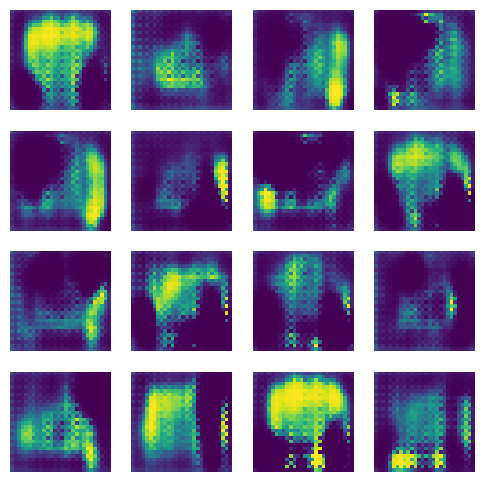

Época 5/10
Pérdida del discriminador: 1.3981341123580933, Pérdida del generador: 0.6966607570648193
Pérdida del discriminador: 1.3880788087844849, Pérdida del generador: 0.6985213756561279
Pérdida del discriminador: 1.3592246770858765, Pérdida del generador: 0.6998757123947144
Pérdida del discriminador: 1.408290147781372, Pérdida del generador: 0.6937573552131653
Pérdida del discriminador: 1.4461764097213745, Pérdida del generador: 0.6900191307067871
Pérdida del discriminador: 1.3796147108078003, Pérdida del generador: 0.6884816884994507
Pérdida del discriminador: 1.3508466482162476, Pérdida del generador: 0.6731777191162109
Pérdida del discriminador: 1.441720962524414, Pérdida del generador: 0.6836338043212891
Pérdida del discriminador: 1.388485074043274, Pérdida del generador: 0.6773456931114197
Pérdida del discriminador: 1.4432493448257446, Pérdida del generador: 0.6762774586677551
Pérdida del discriminador: 1.5201983451843262, Pérdida del generador: 0.6465993523597717
Pérdida del d

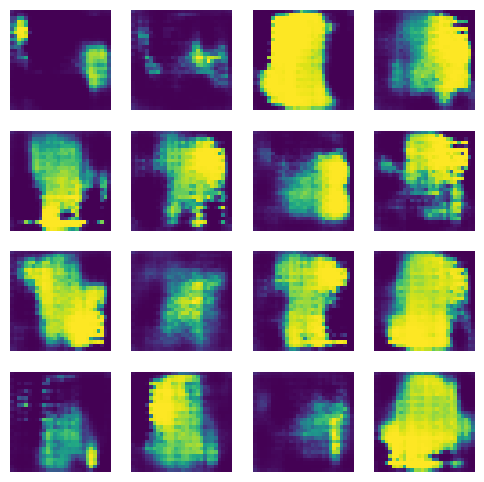

Época 7/10
Pérdida del discriminador: 1.3404183387756348, Pérdida del generador: 0.7866451144218445
Pérdida del discriminador: 1.3599101305007935, Pérdida del generador: 0.7982704639434814
Pérdida del discriminador: 1.3553863763809204, Pérdida del generador: 0.7778372764587402
Pérdida del discriminador: 1.3538166284561157, Pérdida del generador: 0.7674731016159058
Pérdida del discriminador: 1.3533813953399658, Pérdida del generador: 0.7683290243148804
Pérdida del discriminador: 1.3802804946899414, Pérdida del generador: 0.771998405456543
Pérdida del discriminador: 1.3544082641601562, Pérdida del generador: 0.7679520845413208
Pérdida del discriminador: 1.3673092126846313, Pérdida del generador: 0.7251765131950378
Pérdida del discriminador: 1.3859782218933105, Pérdida del generador: 0.7296619415283203
Pérdida del discriminador: 1.3606133460998535, Pérdida del generador: 0.7178575992584229
Pérdida del discriminador: 1.4074642658233643, Pérdida del generador: 0.6931413412094116
Pérdida del

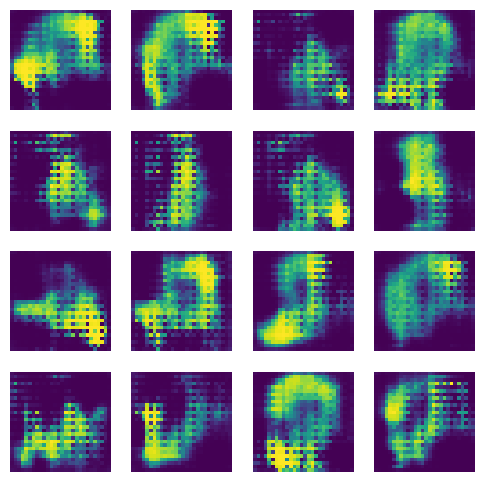

Época 9/10
Pérdida del discriminador: 1.3764033317565918, Pérdida del generador: 0.7287683486938477
Pérdida del discriminador: 1.3550658226013184, Pérdida del generador: 0.7369542121887207
Pérdida del discriminador: 1.3585717678070068, Pérdida del generador: 0.7353976964950562
Pérdida del discriminador: 1.3758985996246338, Pérdida del generador: 0.740730881690979
Pérdida del discriminador: 1.351511836051941, Pérdida del generador: 0.7350477576255798
Pérdida del discriminador: 1.3473623991012573, Pérdida del generador: 0.7244505286216736
Pérdida del discriminador: 1.3244671821594238, Pérdida del generador: 0.7289133667945862
Pérdida del discriminador: 1.3273670673370361, Pérdida del generador: 0.7277513742446899
Pérdida del discriminador: 1.3145928382873535, Pérdida del generador: 0.7383289933204651
Pérdida del discriminador: 1.3313344717025757, Pérdida del generador: 0.7273619174957275
Pérdida del discriminador: 1.3072367906570435, Pérdida del generador: 0.7112573981285095
Pérdida del 

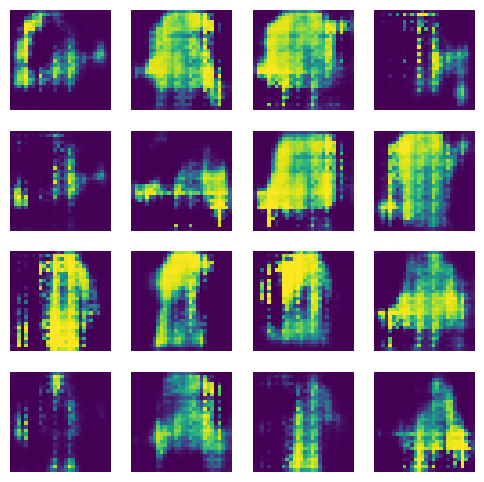

In [ ]:
# Entrenamiento de la GAN
for epoch in range(EPOCHS):
    print(f"Época {epoch + 1}/{EPOCHS}")

    for real_images in train_dataset:
        # Obtiene el tamaño del lote actual
        current_batch_size = real_images.shape[0]

        # Genera ruido aleatorio para crear imágenes falsas
        noise = tf.random.normal([current_batch_size, LATENT_DIM])

        # Crea imágenes falsas con el generador
        generated_images = generator(noise, training=True)

        # Etiquetas realies y falsas
        real_labels = tf.ones((current_batch_size, 1)) # Imágenes reales (etiqueta = 1)
        fake_labels = tf.zeros((current_batch_size, 1)) # Imágenes generadas (etiqueta = 0)

        # Entrena el discriminador
        with tf.GradientTape() as disc_tape: # Crea un contexto de gradiente para calcular la pérdida del discriminador.
            # Obtiene las predicciones del discriminador para las imágenes reales.
            real_output = discriminator(real_images, training=True)
            # Obtiene las predicciones del discriminador para las imágenes falsas/generadas.
            fake_output = discriminator(generated_images, training=True)
            # Calcula la pérdida del discriminador para las imágenes reales.
            disc_loss_real = cross_entropy(real_labels, real_output)
            # Calcula la pérdida del discriminador para las imágenes generadas (fake).
            disc_loss_fake = cross_entropy(fake_labels, fake_output)
            # Suma ambas pérdidas para obtener la pérdida todal del discriminador.
            disc_loss = disc_loss_real + disc_loss_fake

        # Calcula los gradientes de la pérdida con respecto a las variables entrenables del discriminador
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        # Aplica los gradientes para actualizar los pesos del discriminador.
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        # Genera ruido nuevamente para entrenar el generador
        noise = tf.random.normal([current_batch_size, LATENT_DIM])

        # Entrena el generador
        with tf.GradientTape() as gen_tape: # Crea un contexto de gradiente para calcular la pérdida del generador.
            # Crea imágenes falsas con el generador
            generated_images = generator(noise, training=True)
            # Evalúa las imágenes generadas con el discriminador (sin actualizar los pesos).
            fake_output = discriminator(generated_images, training=False)
            # Calcula la pérdida del generador intentando "engañar" al discriminador.
            gen_loss = cross_entropy(real_labels, fake_output)

        # Calcula los gradientes de la pérdida con respecto a las variables entrenables del generador.
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        # Aplica los gradientes para actualizar los pesos del generador.
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        # Muestra la pérdida de cada red neuronal
        print(f"Pérdida del discriminador: {disc_loss.numpy()}, Pérdida del generador: {gen_loss.numpy()}")

    # Guarda la GAN en ficheros
    # Graba en disco los modelos
    generator.save(f"generador_ropa_{epoch + 1}ep_1000img.keras")
    discriminator.save(f"discriminador_ropa_{epoch + 1}ep_1000img.keras")


    # Muestra el progreso cada 2 épocas
    if (epoch + 1) % 2 == 0 or epoch == EPOCHS - 1:
        # Genera y muestra imágenes de ejemplo
        noise = tf.random.normal([16, LATENT_DIM])
        generated_images = generator(noise, training=False)
        generated_images = (generated_images + 1) / 2 # Reescala de [-1, 1] a [0, 1]

        fig, axes = plt.subplots(4, 4, figsize=(6, 6))
        for img, ax in zip(generated_images, axes.flatten()):
            ax.imshow(img)
            ax.axis("off")
        plt.show()

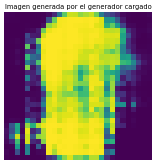

In [ ]:
# Prueba el generador cargado
noise = tf.random.normal([1, LATENT_DIM])
generated_image = generator(noise, training=False)

# Muestra la imagen generada por el generador cargado
plt.figure(dpi=40)
plt.imshow((generated_image[0] + 1) / 2)  # Reescala la imagen al rango [0, 1]
plt.axis('off')
plt.title("Imagen generada por el generador cargado")
plt.show()